# Демонстрация автоматического отбора признаков с помощью PrimarySelection

## Структура ноутбука:
- Применение библиотеки PrimarySelection для задач регрессии
    * Приведение числовых признаков к типу float, замена бесконечных значений;
    * Проверка на пропущенные значения;
    * Корреляционный анализ;
    * Анализ признаков относительно глубины алгоритма;
    * Проверка всех библиотек Permutation Importance (sklearn, eli5, собственный kib)   

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, mean_absolute_percentage_error

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, NansAnalysis, PrimarySelection, base_pipe

* sklearn:  0.24.2
* xgboost:  1.5.2
* matplotlib:  3.1.1
* autobinary:  1.0.3

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  1.0.2
xgboost:  1.5.2
matplotlib:  3.5.1
autobinary:  1.0.6


In [5]:
import numpy as np
np.__version__

'1.21.5'

In [6]:
import scipy
scipy.__version__

'1.7.3'

In [7]:
# eli5==0.13.0

# Для регрессии

In [8]:
sample = pd.read_csv('../data/train_houseprice.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [9]:
num_columns = [
    'LotArea', 'LotFrontage', 'TotalBsmtSF', 'PoolArea', 'FullBath'
]

cat_columns = [
    'BldgType', 'CentralAir', 'GarageQual', 'Fence', 'SaleType'
]

features = num_columns+cat_columns

target = 'SalePrice'

In [10]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [11]:
# обработка бесконечных и пропущенных значений

nans = NansAnalysis(df=sample)

sample = nans.to_types(num_columns=num_columns)
sample.head()

Все бесконечные значения заменены на пропуски, количественные переменные приведены к типу float!


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450.0,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600.0,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250.0,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550.0,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260.0,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
# Проводим анализ на пропущенные значения. Столбцы имеющие пропусков больше percent.

feat_after_nans = nans.fit(percent = 0.9)

# Обновляем факторы

num_columns = list(filter(lambda x: x in feat_after_nans, num_columns))
cat_columns = list(filter(lambda x: x in feat_after_nans, cat_columns))

,feature,cnt_null,share_nans
72,PoolQC,1453,1.00
74,MiscFeature,1406,0.96
6,Alley,1369,0.94
73,Fence,1179,0.81
57,FireplaceQu,690,0.47


Количество столбцов до: 81
Удалены столбцы, имеющие долю пропусков > 90.0 %, количество оставшихся : 78 


In [13]:
# Функция nans_df - датафрейм с пропущенными значениями

nans.nans_df

,feature,cnt_null,share_nans
72,PoolQC,1453,1.00
74,MiscFeature,1406,0.96
6,Alley,1369,0.94
73,Fence,1179,0.81
57,FireplaceQu,690,0.47
...,...,...,...
27,ExterQual,0,0.00
24,Exterior2nd,0,0.00
23,Exterior1st,0,0.00
22,RoofMatl,0,0.00


In [14]:
# Разделение на обучение и тест

X_train, X_val, y_train, y_val = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    random_state=42
)

# Использование класса PrimarySelection

### Класс PrimarySelection используется для анализа качества данных и отбора факторов.

* В параметры передаются тренировочная выборка, пайплайн обработки факторов, количественные и категориальные списки факторов, название таргета, тип модели и тип задачи.

In [15]:
# Инициализация класса первичного отбора факторов

feature_selection = PrimarySelection(df_train=X_train,
                                     base_pipe=base_pipe,
                                     num_columns=num_columns,
                                     cat_columns=cat_columns,
                                     target=target,
                                     model_type='lightboost',
                                     task_type='regression')

Класс первичного отбора факторов инициализирован!


## 1. Корреляционный анализ

* method - метод расчета корреляций (spearman / pearson);
* threshold - порог при котором фактор является коррелирующим;
* drop_with_most_correlations:
    * True - исключается фактор с наибольшим количеством коррелирующих с ним факторов с корреляцией выше порогового значения;
    * False - исключается фактор с наименьшим Джини из списка коррелирующих факторов.

In [16]:
# Корреляционный анализ 

feat_after_corr = feature_selection.corr_analysis(method='spearman',
                                                  threshold=0.4, 
                                                  drop_with_most_correlations=True)

Определены количественные и категориальные переменные!
Количество факторов до: 10
Количество факторов после корреляционного анализа: 10


In [17]:
# функция corr_df - датафрейм с коррелирующими факторами

feature_selection.corr_df

""


In [18]:
# функция metric_res - датафрейм с метриками однофакторного анализа

feature_selection.metric_res

,metric
LotFrontage,3.088937e+37
FullBath,5.462000e+00
PoolArea,5.461800e+00
TotalBsmtSF,5.391700e+00
LotArea,4.778500e+00
SaleType,1.290000e-01
GarageQual,8.220000e-02
CentralAir,7.240000e-02
BldgType,4.020000e-02
Fence,3.170000e-02


In [19]:
# Функция feat_after_corr - список факторов после корреляционного анализа

feature_selection.feat_after_corr

['PoolArea',
 'TotalBsmtSF',
 'GarageQual',
 'SaleType',
 'LotFrontage',
 'BldgType',
 'CentralAir',
 'Fence',
 'FullBath',
 'LotArea']

## 2. Отбор признаков с помощью углубления древовидных алгоритмов

### Метод depth_analysis используется для отбора факторов относительно глубины алгоритма.

* В параметры передаются список факторов и максимальная глубина до которой будут расчитываться важности признаков.


* На выходе мы получаем таблицу из факторов отсортированных по важности, таблицу из факторов отрсортированных по рангу признака, список факторов из отсортированных по важности, список факторов из отсортированных по рангу.


    * Аргоритм отбора относительно глубины: модель обучается на всех факторах в цикле с глубиной от 1 до максимально указанной. Далее выводятся важности по каждому признаку в каждой глубине. После чего значение усредняется по каждому признаку и сортируется по убыванию.
    
    * Алгоритм отбора относительно ранга в глубине: аналогично предыдущему, только при каждом значении глубины отбираются признаки со значением важности >0, по ним расставляются ранговые значения, и расчитывается среднее внутри каждой глубины. После чего ранги усредняются относительно глубин и сортируются по убыванию.

In [20]:
# Анализ относительно глубины

depth_features, rank_features = feature_selection.depth_analysis(features=feat_after_corr,
                                                                 max_depth=3)

Определены количественные и категориальные переменные!


  0%|          | 0/3 [00:00<?, ?it/s]

Количество признаков до отбора: 10
Количество признаков после mean importance относительно глубины: 9
Количество признаков после mean rank относительно глубины: 9


,importance_depth_1,importance_depth_2,importance_depth_3,mean_importance,mean_rank
TotalBsmtSF,9.226884e+13,1.110631e+14,1.185829e+14,1.073049e+14,0.216667
FullBath,5.552127e+13,4.848674e+13,4.808358e+13,5.069720e+13,0.189947
LotArea,2.096092e+13,2.381801e+13,2.330894e+13,2.269595e+13,0.163228
BldgType,4.398684e+12,1.046029e+13,1.019372e+13,8.350898e+12,0.124603
SaleType,7.034262e+12,7.741889e+12,8.001946e+12,7.592699e+12,0.121693


# 3. Проверка Permutation Importance на одной модели с разными алгоритмами sklearn, eli5, собственный код (kib)

    * Код является примером. Не обязательно использовать все три способа. Необходимо отталкиваться от размера выборки и типа задачи (классификация, мультикласс, регрессия). Для задач классификации наиболее оптимальными являются eli5 / kib. Для задач регрессии kib / sklearn.
    
    * Для начала применяем конвеер трансформации категориальных и численных признаков, после чего обучаем алгоритм при наших ранее заданных параметрах.

In [21]:
strat = KFold(
    n_splits=3,
    shuffle=True,
    random_state=42)

* На вход подаются список факторов после анализа относительно глубины / корреляционного анализа / анализа пропусков, стратегия деления, количество перемешиваний, тип перемешивания, число ядер, метрика и направление метрики (для типа перемешивания kib)

### 3.1 От Sklearn

In [22]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       n_iter=10,
                                       permute_type='sklearn',
                                       n_jobs=-1,
 #                                      metric=roc_auc_score,
 #                                      higher_is_better=True
                                      )

Размер обучающего подмножества для Permutation importance: (681, 81) ; Среднее значение таргета: 184182.06607929515

Размер тестового подмножества для Permutation importance: (341, 81) ; Среднее значение таргета: 175582.36070381233
Определены количественные и категориальные переменные!


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
TotalBsmtSF,0.527951,0.404515
FullBath,0.191355,0.207280
LotArea,0.138861,0.080736
BldgType,0.029725,0.039806
SaleType,0.042562,0.025172
CentralAir,0.013404,0.020808
GarageQual,0.006989,0.009772
Fence,0.007919,0.008792
LotFrontage,0.045190,0.003277


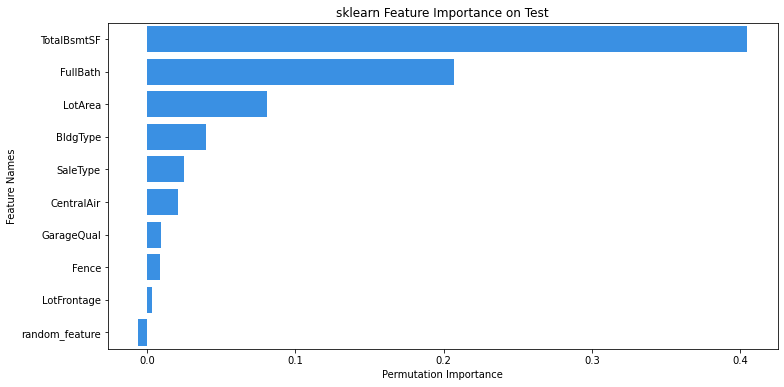

In [23]:
# вызов функции permutation_plot отрисовывает топ важности по методу permutation importance

feature_selection.permutation_plot(top=10, figsize=(12,6))

#### Вызов функции select_features выдает список отобранных признаков. 

* Отбор происходит следующим образом:
    * Если на тестовом множестве значение метрики относительно перемешанного факторо и рандомного признака ниже нуля, то отбираются все признаки выше нуля.
    * Если рандомный признак имеет положительное значение на тестовом множестве, то отбираются все признаки выше значения при рандомном признаке.

In [24]:
feature_selection.select_features()

10 признаков было до Permutation Importance 

9 признаков после Permutation Importance от sklearn


['TotalBsmtSF',
 'FullBath',
 'LotArea',
 'BldgType',
 'SaleType',
 'CentralAir',
 'GarageQual',
 'Fence',
 'LotFrontage']

### 3.2 От Eli5

In [25]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       n_iter=10,
                                       permute_type='eli5',
 #                                      n_jobs=-1,
 #                                      metric=roc_auc_score,
 #                                      higher_is_better=True
                                      )

Размер обучающего подмножества для Permutation importance: (681, 81) ; Среднее значение таргета: 184182.06607929515

Размер тестового подмножества для Permutation importance: (341, 81) ; Среднее значение таргета: 175582.36070381233
Определены количественные и категориальные переменные!


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
TotalBsmtSF,0.540670,0.400078
FullBath,0.189956,0.193612
LotArea,0.143082,0.081503
BldgType,0.031536,0.047012
CentralAir,0.013487,0.021595
SaleType,0.043739,0.019803
GarageQual,0.006789,0.008332
Fence,0.007496,0.007929
LotFrontage,0.045478,0.004862


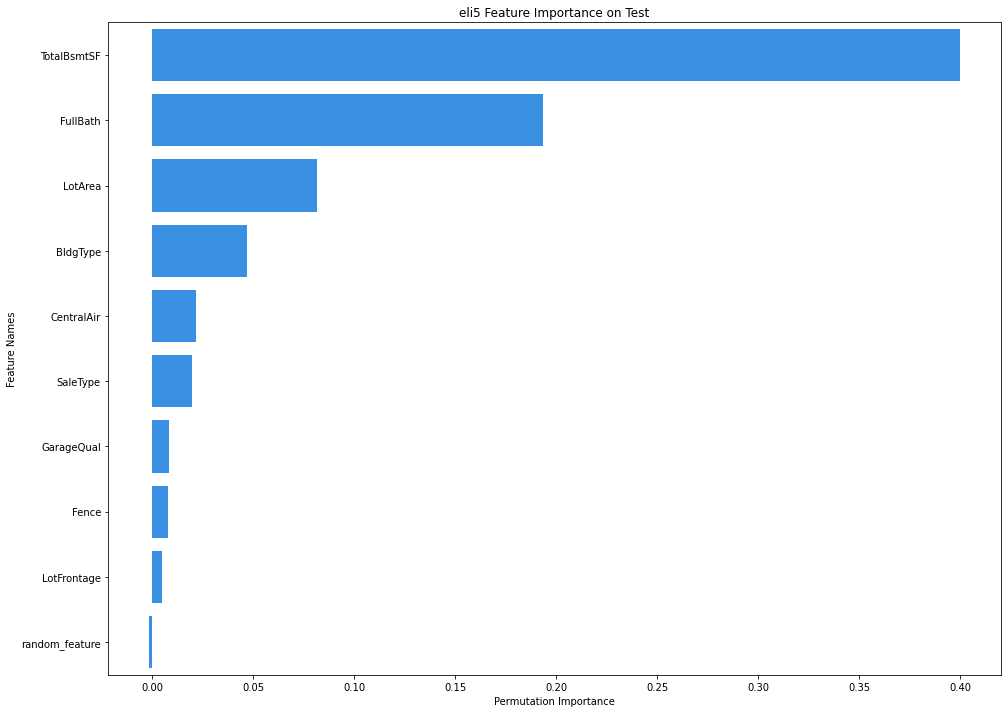

In [26]:
feature_selection.permutation_plot(figsize=(16,12), top=10)

In [27]:
feature_selection.select_features()

10 признаков было до Permutation Importance 

9 признаков после Permutation Importance от eli5


['TotalBsmtSF',
 'FullBath',
 'LotArea',
 'BldgType',
 'CentralAir',
 'SaleType',
 'GarageQual',
 'Fence',
 'LotFrontage']

### 3.3 Самописный permutation kib

In [28]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       n_iter=10,
                                       permute_type='kib',
                                       n_jobs=-1,
                                       metric=mean_absolute_percentage_error,
                                       higher_is_better=False)

Размер обучающего подмножества для Permutation importance: (681, 81) ; Среднее значение таргета: 184182.06607929515

Размер тестового подмножества для Permutation importance: (341, 81) ; Среднее значение таргета: 175582.36070381233
Определены количественные и категориальные переменные!
Расчет Permutation Importance на Train


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Расчет Permutation Importance на Test


100%|██████████| 10/10 [00:00<00:00, 29.06it/s]


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
TotalBsmtSF,0.406184,0.456472
FullBath,0.368309,0.447685
LotArea,0.323394,0.394132
CentralAir,0.294134,0.386004
BldgType,0.289646,0.384192
GarageQual,0.290146,0.378980
SaleType,0.290986,0.378784
Fence,0.282247,0.374983
LotFrontage,0.292952,0.372621


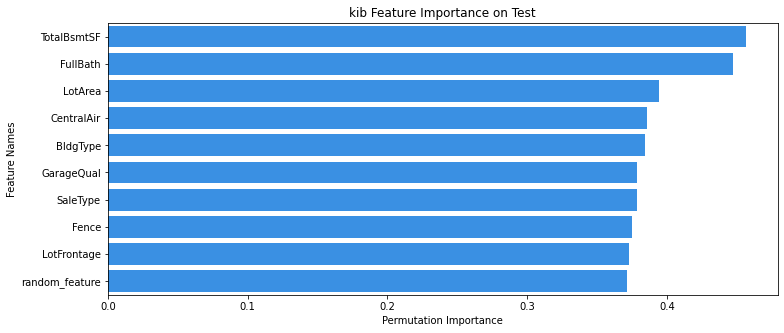

In [29]:
feature_selection.permutation_plot(top=10, figsize=(12,5))

In [30]:
feature_selection.select_features()

10 признаков было до Permutation Importance 

9 признаков после Permutation Importance от kib


['TotalBsmtSF',
 'FullBath',
 'LotArea',
 'CentralAir',
 'BldgType',
 'GarageQual',
 'SaleType',
 'Fence',
 'LotFrontage']